In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bernoulli
from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from tqdm import tqdm

In [2]:
def rbf(x,y,l=1):
    """Gaussian kernel

    Parameters
    -------------------------------
    x : float
    a real number

    y : float
    a real number

    l: float, non zero
    a scale parameter
    -------------------------------
    """
    dim = x.shape[0]
    vect = np.empty(dim)
    if dim == y.shape[0]  :
        d = np.exp(-((np.linalg.norm(x-y))**2)/(2*(l**2)))
        return d
    else :
        for i in range(dim):
            vect[i] = np.exp(-((np.linalg.norm(x[i] - y))**2)/(2*(l**2)))
        return vect

In [3]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([2,2]),
                                             cov=np.array(([1,-0.25],[-0.25,1])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=1.0, high=3.0, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2)*0.5,
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-2, high=-1, size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

In [4]:
for i in range(2*n_gen):
    random = bernoulli.rvs(p=3/4)
    if random == 1:
        whole_data[i,2] = -1
positive_data = np.zeros((1,3))
unlabeled_data = np.zeros((1,3))
for i in range(n_samples):
    if whole_data[i,2] == 1:
        positive_data = np.vstack((positive_data, whole_data[i,:]))
    else:
        unlabeled_data = np.vstack((unlabeled_data, whole_data[i,:]))

positive_data = np.delete(positive_data,0,0)
unlabeled_data = np.delete(unlabeled_data,0,0)
pu_data = np.vstack((positive_data,unlabeled_data))

In [5]:
pu_data[:,:2],pu_data[:,2] = shuffle(pu_data[:,:2],pu_data[:,2])
pu_data_train = pu_data[:,:2][:int(n_samples*0.8)]
output_train = pu_data[:,2][:int(n_samples*0.8)]

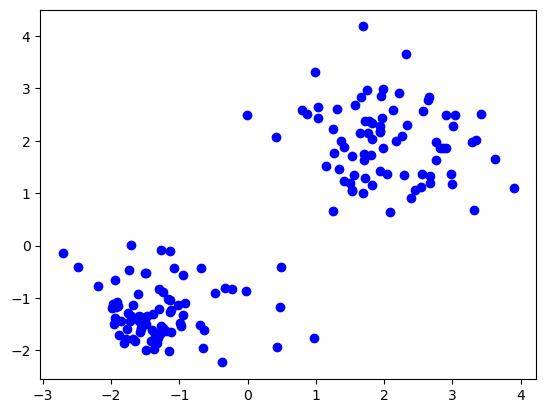

In [6]:
plt.plot(pu_data_train[:,0], pu_data_train[:,1], 'bo')

In [7]:
list_of_inertia = np.empty(8)
for i in range(1,9):
    list_of_inertia[i-1] = KMeans(n_clusters=i).fit(X=pu_data_train).inertia_

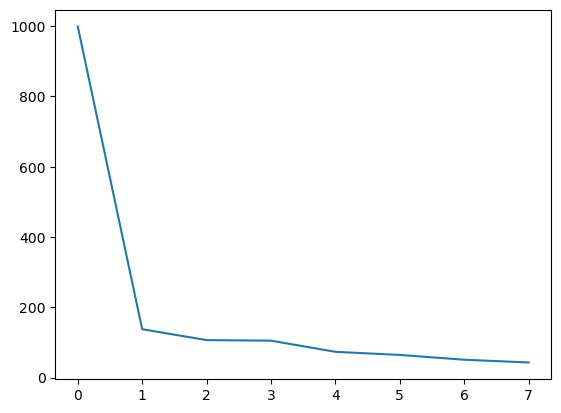

In [8]:
plt.plot(list_of_inertia)

In [9]:
#let's take 3

In [10]:
pu_df = pd.DataFrame(pu_data_train)
pu_df['label'] = output_train
n_cluster = 3
clusterized_data = KMeans(n_clusters=n_cluster, init='random').fit(pu_data_train)
pu_df['cluster'] = clusterized_data.labels_

list_of_ratio = []
for i in range(n_cluster):
    list_of_ratio.append(pu_df[pu_df['cluster'] == i]['label'].sum()/pu_df[pu_df['cluster'] == i].shape[0])
list_of_ratio = np.array(list_of_ratio)
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)
print('the cluster containing positive values is : ', positive_cluster, '\n', 
      'the one containing negative exampels is : ', negative_cluster)

reliable_positives = pu_df[pu_df['cluster'] == positive_cluster]
reliable_positives = reliable_positives[reliable_positives['label'] == 1]
reliable_negatives = pu_df[pu_df['cluster'] == negative_cluster]
reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]

the cluster containing positive values is :  0 
 the one containing negative exampels is :  1


In [11]:
#first svm part
n_fit = pu_data_train.shape[0]
gamma = 1
positives_array = reliable_positives.drop(['cluster'], axis=1)
negatives_array = reliable_negatives.drop(['cluster'], axis=1)
data_svm = np.vstack((positives_array,negatives_array))
n_reliable = data_svm.shape[0]
outcome = data_svm[:,-1]
data_svm = data_svm[:,:-1]
omega = np.zeros((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(k,n_reliable):
        omega[k,i] = outcome[k]*outcome[i]*rbf(x=data_svm[k,:],y=data_svm[i,:],l=1)
omega_t = np.transpose(omega)
omega = omega_t + omega
for i in range(n_reliable):
    omega[i,i] = 1


#now, computation of the rest of the matrix
first_row = np.hstack((0,-np.transpose(outcome)))
first_row = first_row.reshape(1,first_row.shape[0])
bot_of_mat_right = omega + (1/gamma)*np.eye(n_reliable)
bot_of_mat = np.hstack((outcome.reshape(n_reliable,1), bot_of_mat_right))
whole_mat = np.vstack((first_row, bot_of_mat))
right_hand = np.ones(n_reliable+1)
right_hand[0] = 0

#we get the coefficients
coeffs = np.linalg.solve(a=whole_mat,b=right_hand)
b = coeffs[0]
alpha = coeffs[1:coeffs.shape[0]]

#now we compute the wt \phi(x) and then we order them 
test_data = pu_df.drop(['label','cluster'], axis=1).to_numpy()
results = np.empty(n_fit)
for i in tqdm(range(n_fit)):
    results[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=test_data[i,:],l=1))
sorted_results = np.sort(results)
good_ratio = int(n_fit/2)
b = sorted_results[good_ratio]

last_results = np.empty(n_fit)
for i in range(n_fit):
    last_results[i] = np.sign(results[i] - b)

pu_df['it_results'] = last_results
correct_with_b = 0
for i in range(reliable_positives.shape[0]):
    if pu_df.loc[reliable_positives.index[i],'it_results'] == 1:
        correct_with_b += 1
missclass = reliable_positives.shape[0] - correct_with_b

100%|██████████| 160/160 [00:00<00:00, 3486.32it/s]


100%|██████████| 250000/250000 [03:28<00:00, 1201.11it/s]


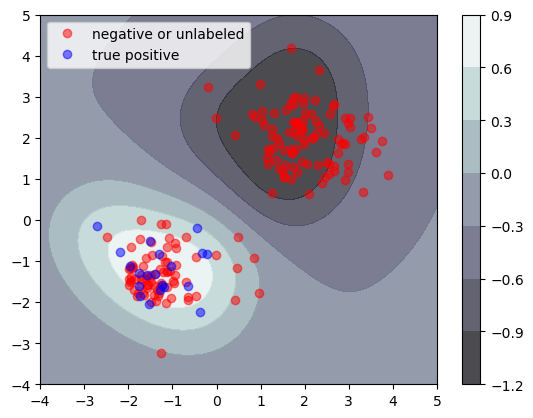

<Figure size 640x480 with 0 Axes>

In [20]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
results_plot = np.empty(500**2)
for i in tqdm(range(500**2)):
    results_plot[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=np.c_[xx.ravel(), yy.ravel()][i,:],l=1))-b
Z = results_plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()
plt.savefig('first_decision_boundary_separable_data.png')

In [21]:
pu_df_it = pu_df.copy()
compteur=0
max_iter=100
good_ratio = int(n_fit/2)
while True and compteur<max_iter:
    compteur+=1
    for i in range(n_fit):
        if pu_df_it.loc[pu_df.index[i],'it_results'] == 0:
            pu_df_it.loc[pu_df.index[i],'it_results'] = -1
    positives_new = pu_df_it[pu_df_it['it_results'] == 1]
    positives_new = positives_new[positives_new['label'] == 1]
    negatives_new = pu_df_it[pu_df_it['it_results'] == -1]
    negatives_new = negatives_new[negatives_new['label'] == -1]
    negatives_new = negatives_new.sample(n=positives_new.shape[0])
    #first svm part
    gamma = 1
    positives_array_new = positives_new.drop(['cluster','label'], axis=1)
    negatives_array_new = negatives_new.drop(['cluster','label'], axis=1)
    data_svm_it = np.vstack((positives_array_new,negatives_array_new))
    n_reliable = data_svm_it.shape[0]
    outcome_it = data_svm_it[:,-1].copy()
    data_svm_it = data_svm_it[:,:-1].copy()
    #compute omega
    omega_it = np.zeros((n_reliable,n_reliable))
    for k in range(n_reliable):
        for i in range(k,n_reliable):
            omega_it[k,i] = outcome_it[k]*outcome_it[i]*rbf(x=data_svm_it[k,:],y=data_svm_it[i,:],l=1)
    omega_it_t = np.transpose(omega_it)
    omega_it = omega_it+omega_it_t
    for i in range(n_reliable):
        omega_it[i,i] = 1
    
    first_row_it = np.hstack((0,-np.transpose(outcome_it)))
    first_row_it = first_row_it.reshape(1,first_row_it.shape[0])
    bot_of_mat_right_it = omega_it + (1/gamma)*np.eye(n_reliable)
    bot_of_mat_it = np.hstack((outcome_it.reshape(n_reliable,1), bot_of_mat_right_it))
    whole_mat_it = np.vstack((first_row_it, bot_of_mat_it))
    right_hand_it = np.ones(n_reliable+1)
    right_hand_it[0] = 0
    coeffs_it = np.linalg.solve(a=whole_mat_it,b=right_hand_it)
    b_it = coeffs_it[0]
    alpha_it = coeffs_it[1:coeffs_it.shape[0]]
    test_data_it = pu_df_it.drop(['label','cluster','it_results'], axis=1).to_numpy()
    results_new = np.empty(n_fit)
    #the results in the previous algo is now 'new_results'

    
    for i in range(n_fit):
        results_new[i] = np.sum(alpha_it*outcome_it*rbf(x=data_svm_it,y=test_data_it[i,:],l=1))
    sorted_results_it = np.sort(results_new)
    b_it = sorted_results_it[good_ratio]
    last_results_it = np.empty(n_fit)
    for i in range(n_fit):
        last_results_it[i] = np.sign(results_new[i] - b)
    correct_with_b_it = 0 
    for i in range(pu_df_it[pu_df['label'] == 1].shape[0]):
        if last_results_it[i] == 1:
            correct_with_b_it += 1
    missclass_it = positives_new.shape[0] - correct_with_b_it
    compteur_bis = 0
    max_iter_bis = 200
    while missclass_it!=0 and compteur_bis<max_iter_bis:
        compteur_bis += 1
        b_it = (1-0.05)*b_it
        last_results_bis = np.empty(n_fit)
        for i in range(n_fit):
            last_results_bis[i] = np.sign(results_new[i] - b_it)
        correct_with_b_bis = 0

        for i in range(pu_df_it[pu_df['label'] == 1].shape[0]):
            if last_results_bis[i] == 1:
                correct_with_b_bis += 1
        missclass_it = positives_new.shape[0] - correct_with_b_bis
    stop_counter = 0
    for i in range(n_fit):
        if pu_df_it.loc[pu_df.index[i],'it_results'] != last_results_bis[i]:
            stop_counter += 1
    if stop_counter == 0:
        break
        compteur = max_iter
    else:
        pu_df_it['it_results'] = last_results_bis
alpha_it_final = alpha_it.copy()
outcome_it_final = outcome_it.copy()

100%|██████████| 250000/250000 [02:39<00:00, 1565.43it/s]


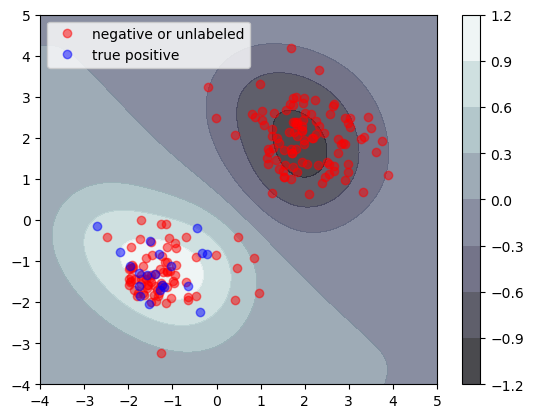

<Figure size 640x480 with 0 Axes>

In [22]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
results_plot = np.empty(500**2)
for i in tqdm(range(500**2)):
    results_plot[i] = np.sum(alpha_it_final*outcome_it*rbf(x=data_svm_it,y=np.c_[xx.ravel(), yy.ravel()][i,:],l=1))-b_it
Z = results_plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()
plt.savefig('last_decision_boundary_after_100_it_sep_data.png')

In [23]:
#The graphical boundaries seem to be quite good.

In [24]:
n_gen_test = 10
n_samples_test = 4*n_gen_test
data_n_test_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen_test)
data_n_test_2 = np.random.uniform(low=0.5, high=2., size=(n_gen_test,2))

data_p_test_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen_test)
data_p_test_2 = np.random.uniform(low=-1, high=0., size=(n_gen_test,2))

data_test = np.vstack((data_n_test_1,data_n_test_2,data_p_test_1,data_p_test_2))
data_test = np.hstack((data_test,np.hstack((np.ones(n_gen_test*2)*(-1),np.ones(n_gen_test*2))).reshape(n_samples_test,1)))

In [25]:
predictions_test = np.empty(n_samples_test)
for i in range(n_samples_test):
    predictions_test[i] = np.sign(np.sum(alpha_it_final*outcome_it*rbf(x=data_svm_it,y=data_test[i,:-1],l=1))-b_it)

positive_prediction_test = 0
true_positive_prediction_test = 0
for i in range(data_test.shape[0]):
    if predictions_test[i] == 1:
        positive_prediction_test += 1
        if data_test[i,2] == 1:
            true_positive_prediction_test += 1

print('the precision on the test data is : ', true_positive_prediction_test/positive_prediction_test)

the precision on the test data is :  0.8333333333333334


In [26]:
positive_prediction_test

24

In [27]:
true_positive_prediction_test

20

### Now, let's try on a less separable dataset

In [3]:
np.random.seed(1457065)
n_gen = 50
n_samples = 4*n_gen
data_red_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen)
data_red_2 = np.random.uniform(low=0.5, high=2, size=(n_gen,2))

data_blue_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen)
data_blue_2 = np.random.uniform(low=-1, high=0., size=(n_gen,2))

data_red = np.vstack((data_red_1,data_red_2))
labels_red = (np.ones(2*n_gen)*-1).reshape(2*n_gen,1)
data_red = np.hstack((data_red,labels_red))

data_blue = np.vstack((data_blue_1, data_blue_2))
labels_blue = (np.ones(2*n_gen)).reshape(2*n_gen,1)
data_blue = np.hstack((data_blue,labels_blue))

whole_data = np.vstack((data_blue, data_red))

In [4]:
for i in range(2*n_gen):
    random = bernoulli.rvs(p=3/4)
    if random == 1:
        whole_data[i,2] = -1
positive_data = np.zeros((1,3))
unlabeled_data = np.zeros((1,3))
for i in range(n_samples):
    if whole_data[i,2] == 1:
        positive_data = np.vstack((positive_data, whole_data[i,:]))
    else:
        unlabeled_data = np.vstack((unlabeled_data, whole_data[i,:]))

positive_data = np.delete(positive_data,0,0)
unlabeled_data = np.delete(unlabeled_data,0,0)
pu_data = np.vstack((positive_data,unlabeled_data))

In [5]:
pu_data[:,:2],pu_data[:,2] = shuffle(pu_data[:,:2],pu_data[:,2])
pu_data_train = pu_data[:,:2][:int(n_samples*0.8)]
output_train = pu_data[:,2][:int(n_samples*0.8)]

In [6]:
pu_df = pd.DataFrame(pu_data_train)
pu_df['label'] = output_train
n_cluster = 3
clusterized_data = KMeans(n_clusters=n_cluster, init='random').fit(pu_data_train)
pu_df['cluster'] = clusterized_data.labels_

list_of_ratio = []
for i in range(n_cluster):
    list_of_ratio.append(pu_df[pu_df['cluster'] == i]['label'].sum()/pu_df[pu_df['cluster'] == i].shape[0])
list_of_ratio = np.array(list_of_ratio)
positive_cluster = np.argmax(list_of_ratio)
negative_cluster = np.argmin(list_of_ratio)
print('the cluster containing positive values is : ', positive_cluster, '\n', 
      'the one containing negative exampels is : ', negative_cluster)

reliable_positives = pu_df[pu_df['cluster'] == positive_cluster]
reliable_positives = reliable_positives[reliable_positives['label'] == 1]
reliable_negatives = pu_df[pu_df['cluster'] == negative_cluster]
reliable_negatives = reliable_negatives[reliable_negatives['label'] == -1]

the cluster containing positive values is :  2 
 the one containing negative exampels is :  1


In [7]:
#first svm part
n_fit = pu_data_train.shape[0]
gamma = 1
positives_array = reliable_positives.drop(['cluster'], axis=1)
negatives_array = reliable_negatives.drop(['cluster'], axis=1)
data_svm = np.vstack((positives_array,negatives_array))
n_reliable = data_svm.shape[0]
outcome = data_svm[:,-1]
data_svm = data_svm[:,:-1]
omega = np.zeros((n_reliable,n_reliable))
for k in range(n_reliable):
    for i in range(k,n_reliable):
        omega[k,i] = outcome[k]*outcome[i]*rbf(x=data_svm[k,:],y=data_svm[i,:],l=1)
omega_t = np.transpose(omega)
omega = omega_t + omega
for i in range(n_reliable):
    omega[i,i] = 1


#now, computation of the rest of the matrix
first_row = np.hstack((0,-np.transpose(outcome)))
first_row = first_row.reshape(1,first_row.shape[0])
bot_of_mat_right = omega + (1/gamma)*np.eye(n_reliable)
bot_of_mat = np.hstack((outcome.reshape(n_reliable,1), bot_of_mat_right))
whole_mat = np.vstack((first_row, bot_of_mat))
right_hand = np.ones(n_reliable+1)
right_hand[0] = 0

#we get the coefficients
coeffs = np.linalg.solve(a=whole_mat,b=right_hand)
b = coeffs[0]
alpha = coeffs[1:coeffs.shape[0]]

#now we compute the wt \phi(x) and then we order them 
test_data = pu_df.drop(['label','cluster'], axis=1).to_numpy()
results = np.empty(n_fit)
for i in tqdm(range(n_fit)):
    results[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=test_data[i,:],l=1))
sorted_results = np.sort(results)
good_ratio = int(n_fit/2)
b = sorted_results[good_ratio]

last_results = np.empty(n_fit)
for i in range(n_fit):
    last_results[i] = np.sign(results[i] - b)

pu_df['it_results'] = last_results
correct_with_b = 0
for i in range(reliable_positives.shape[0]):
    if pu_df.loc[reliable_positives.index[i],'it_results'] == 1:
        correct_with_b += 1
missclass = reliable_positives.shape[0] - correct_with_b

100%|██████████| 160/160 [00:00<00:00, 3154.10it/s]


100%|██████████| 250000/250000 [03:31<00:00, 1181.21it/s]


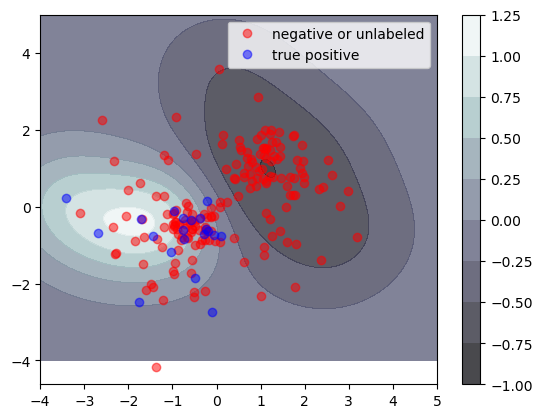

<Figure size 640x480 with 0 Axes>

In [8]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
results_plot = np.empty(500**2)
for i in tqdm(range(500**2)):
    results_plot[i] = np.sum(alpha*outcome*rbf(x=data_svm,y=np.c_[xx.ravel(), yy.ravel()][i,:],l=1))-b
Z = results_plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()
plt.savefig('first_boundary_not_sep_data.png')

In [9]:
pu_df_it = pu_df.copy()
compteur=0
max_iter=100
good_ratio = int(n_fit/2)
while True and compteur<max_iter:
    compteur+=1
    for i in range(n_fit):
        if pu_df_it.loc[pu_df.index[i],'it_results'] == 0:
            pu_df_it.loc[pu_df.index[i],'it_results'] = -1
    positives_new = pu_df_it[pu_df_it['it_results'] == 1]
    positives_new = positives_new[positives_new['label'] == 1]
    negatives_new = pu_df_it[pu_df_it['it_results'] == -1]
    negatives_new = negatives_new[negatives_new['label'] == -1]
    negatives_new = negatives_new.sample(n=positives_new.shape[0])
    #first svm part
    gamma = 1
    positives_array_new = positives_new.drop(['cluster','label'], axis=1)
    negatives_array_new = negatives_new.drop(['cluster','label'], axis=1)
    data_svm_it = np.vstack((positives_array_new,negatives_array_new))
    n_reliable = data_svm_it.shape[0]
    outcome_it = data_svm_it[:,-1].copy()
    data_svm_it = data_svm_it[:,:-1].copy()
    #compute omega
    omega_it = np.zeros((n_reliable,n_reliable))
    for k in range(n_reliable):
        for i in range(k,n_reliable):
            omega_it[k,i] = outcome_it[k]*outcome_it[i]*rbf(x=data_svm_it[k,:],y=data_svm_it[i,:],l=1)
    omega_it_t = np.transpose(omega_it)
    omega_it = omega_it+omega_it_t
    for i in range(n_reliable):
        omega_it[i,i] = 1
    
    first_row_it = np.hstack((0,-np.transpose(outcome_it)))
    first_row_it = first_row_it.reshape(1,first_row_it.shape[0])
    bot_of_mat_right_it = omega_it + (1/gamma)*np.eye(n_reliable)
    bot_of_mat_it = np.hstack((outcome_it.reshape(n_reliable,1), bot_of_mat_right_it))
    whole_mat_it = np.vstack((first_row_it, bot_of_mat_it))
    right_hand_it = np.ones(n_reliable+1)
    right_hand_it[0] = 0
    coeffs_it = np.linalg.solve(a=whole_mat_it,b=right_hand_it)
    b_it = coeffs_it[0]
    alpha_it = coeffs_it[1:coeffs_it.shape[0]]
    test_data_it = pu_df_it.drop(['label','cluster','it_results'], axis=1).to_numpy()
    results_new = np.empty(n_fit)
    #the results in the previous algo is now 'new_results'

    
    for i in range(n_fit):
        results_new[i] = np.sum(alpha_it*outcome_it*rbf(x=data_svm_it,y=test_data_it[i,:],l=1))
    sorted_results_it = np.sort(results_new)
    b_it = sorted_results_it[good_ratio]
    last_results_it = np.empty(n_fit)
    for i in range(n_fit):
        last_results_it[i] = np.sign(results_new[i] - b)
    correct_with_b_it = 0 
    for i in range(pu_df_it[pu_df['label'] == 1].shape[0]):
        if last_results_it[i] == 1:
            correct_with_b_it += 1
    missclass_it = positives_new.shape[0] - correct_with_b_it
    compteur_bis = 0
    max_iter_bis = 200
    while missclass_it!=0 and compteur_bis<max_iter_bis:
        compteur_bis += 1
        b_it = (1-0.05)*b_it
        last_results_bis = np.empty(n_fit)
        for i in range(n_fit):
            last_results_bis[i] = np.sign(results_new[i] - b_it)
        correct_with_b_bis = 0

        for i in range(pu_df_it[pu_df['label'] == 1].shape[0]):
            if last_results_bis[i] == 1:
                correct_with_b_bis += 1
        missclass_it = positives_new.shape[0] - correct_with_b_bis
    stop_counter = 0
    for i in range(n_fit):
        if pu_df_it.loc[pu_df.index[i],'it_results'] != last_results_bis[i]:
            stop_counter += 1
    if stop_counter == 0:
        break
        compteur = max_iter
    else:
        pu_df_it['it_results'] = last_results_bis
alpha_it_final = alpha_it.copy()
outcome_it_final = outcome_it.copy()

100%|██████████| 250000/250000 [02:48<00:00, 1485.49it/s]


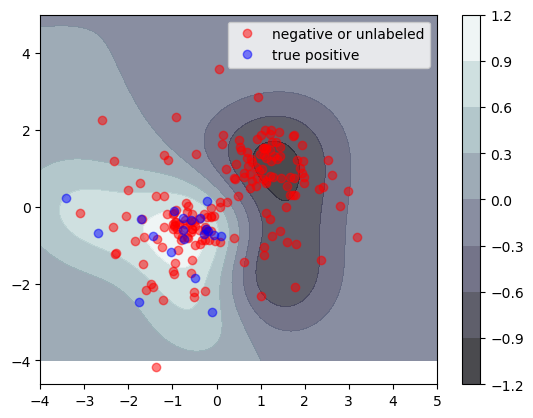

<Figure size 640x480 with 0 Axes>

In [10]:
xx, yy = np.meshgrid(np.linspace(-4,5,500), np.linspace(-4,5,500))
results_plot = np.empty(500**2)
for i in tqdm(range(500**2)):
    results_plot[i] = np.sum(alpha_it_final*outcome_it*rbf(x=data_svm_it,y=np.c_[xx.ravel(), yy.ravel()][i,:],l=1))-b_it
Z = results_plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.bone)
plt.plot(unlabeled_data[:,0],unlabeled_data[:,1],'or', alpha=0.5, label='negative or unlabeled')
plt.plot(positive_data[:,0],positive_data[:,1],'ob',alpha=0.5, label='true positive')
plt.legend()
plt.colorbar()
plt.show()
plt.savefig('last_decision_boundary_not_sep_data_100_it.png')

In [11]:
n_gen_test = 10
n_samples_test = 4*n_gen_test
data_n_test_1 = np.random.multivariate_normal(mean=np.array([0.5,0.5]),
                                             cov=np.array(([2,-0.5],[-0.5,2])),
                                             size=n_gen_test)
data_n_test_2 = np.random.uniform(low=0.5, high=2., size=(n_gen_test,2))

data_p_test_1 = np.random.multivariate_normal(mean=np.array([-1,-1]),
                                            cov=np.eye(2),
                                            size=n_gen_test)
data_p_test_2 = np.random.uniform(low=-1, high=0., size=(n_gen_test,2))

data_test = np.vstack((data_n_test_1,data_n_test_2,data_p_test_1,data_p_test_2))
data_test = np.hstack((data_test,np.hstack((np.ones(n_gen_test*2)*(-1),np.ones(n_gen_test*2))).reshape(n_samples_test,1)))

In [12]:
predictions_test = np.empty(n_samples_test)
for i in range(n_samples_test):
    predictions_test[i] = np.sign(np.sum(alpha_it_final*outcome_it*rbf(x=data_svm_it,y=data_test[i,:-1],l=1))-b_it)

positive_prediction_test = 0
true_positive_prediction_test = 0
for i in range(data_test.shape[0]):
    if predictions_test[i] == 1:
        positive_prediction_test += 1
        if data_test[i,2] == 1:
            true_positive_prediction_test += 1

print('the precision on the test data is : ', true_positive_prediction_test/positive_prediction_test)

the precision on the test data is :  0.8636363636363636


In [13]:
#quite correct as well